In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import tensorflow_probability.substrates.jax as tfp
import matplotlib.pyplot as plt
import arviz as az
import os
import importlib.resources

tfd = tfp.distributions
tfb = tfp.bijectors

from bayesianquilts.model import BayesianModel
from bayesianquilts.vi.minibatch import minibatch_fit_surrogate_posterior
from bayesianquilts.metrics.ais import AdaptiveImportanceSampler
from bayesianquilts.predictors.regression.poisson import PoissonRegressionLikelihood
from bayesianquilts.predictors.regression.poisson import PoissonRegression
jax.config.update("jax_enable_x64", True)


Patched _JointDistributionNamedSpec with _structure_with_callables=None
TFP Specs patched successfully.


In [2]:
# Load the dataset
try:
    data_path = str(importlib.resources.files('bayesianquilts.data').joinpath('roachdata.csv'))
except ImportError:
    # Fallback if package not installed
    data_path = '../../bayesianquilts/data/roachdata.csv'
    if not os.path.exists(data_path):
        data_path = 'bayesianquilts/data/roachdata.csv'

print(f'Loading data from {data_path}')
df = pd.read_csv(data_path)
print(df.head())

# Preprocessing matching Stan implementation
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Scaling roach1
# df['roach1'] = 0.01 * df['roach1']

# Target
y_data = df['y'].values.astype(np.float32)

# Features: roach1, treatment, senior
X_df = df[['roach1', 'treatment', 'senior']].copy()

# Add pairwise interactions
X_df['roach1_treatment'] = X_df['roach1'] * X_df['treatment']
X_df['roach1_senior'] = X_df['roach1'] * X_df['senior']
X_df['treatment_senior'] = X_df['treatment'] * X_df['senior']

X_data = X_df.values.astype(np.float32)

# Offset: log(exposure2)
offset_data = np.log(df['exposure2'].values).astype(np.float32)

print(f'X shape: {X_data.shape}, y shape: {y_data.shape}, offset shape: {offset_data.shape}')


Loading data from /Users/josh/workspace/bayesianquilts/bayesianquilts/data/roachdata.csv
   Unnamed: 0    y  roach1  treatment  senior  exposure2
0           1  153  308.00          1       0   0.800000
1           2  127  331.25          1       0   0.600000
2           3    7    1.67          1       0   1.000000
3           4    7    3.00          1       0   1.000000
4           5    0    2.00          1       0   1.142857
X shape: (262, 6), y shape: (262,), offset shape: (262,)


In [3]:
# Instantiate model (was missing)
# Instantiate model
# Instantiate model with Stan-aligned priors
model = PoissonRegression(
    input_dim=X_data.shape[1],
    prior_scale_beta=2.5,
    prior_scale_intercept=5.0,
    dtype=jnp.float64
)

# Data dictionary for MCMC
data_dict = {
    'X': jnp.array(X_data),
    'y': jnp.array(y_data),
    'offset': jnp.array(offset_data)
}

# PATHFINDER INITIALIZATION FOR MCMC
# ============================================================================

import jax.flatten_util
import blackjax.vi.pathfinder as pathfinder

def pathfinder_initialization(model, data, num_chains=4, num_samples=200, maxiter=100, 
                              ftol=1e-6, gtol=1e-9, verbose=True):
    """
    Use Pathfinder variational inference to initialize MCMC chains.
    """
    if verbose:
        print('\nStep 1: Running Pathfinder variational inference...')

    # Setup parameter flattening
    key = jax.random.PRNGKey(0)
    # This should now work after the library fix
    prior_sample = model.prior_distribution.sample(1, seed=key)
    template = {var: prior_sample[var][0] for var in model.var_list}
    flat_template, unflatten_fn = jax.flatten_util.ravel_pytree(template)
    param_dim = flat_template.shape[0]

    if verbose:
        print(f'  Parameter space dimension: {param_dim}')

    def logprob_fn_flat(params_flat):
        params_dict = unflatten_fn(params_flat)
        return model.unormalized_log_prob(data=data, **params_dict)

    initial_position = jax.random.normal(jax.random.PRNGKey(42), (param_dim,)) * 0.1

    state, info = pathfinder.approximate(
        rng_key=jax.random.PRNGKey(123),
        logdensity_fn=logprob_fn_flat,
        initial_position=initial_position,
        num_samples=num_samples,
        maxiter=maxiter,
        ftol=ftol,
        gtol=gtol,
    )

    if verbose:
        print(f'  ✓ Pathfinder converged! ELBO: {float(state.elbo):.3f}')

    if verbose:
        print(f'\nStep 2: Sampling {num_chains} diverse initial states...')

    sample_key = jax.random.PRNGKey(456)
    samples_result = pathfinder.sample(sample_key, state, num_samples=num_chains)
    samples_flat = samples_result[0] if isinstance(samples_result, tuple) else samples_result

    chain_inits = {var: [] for var in model.var_list}

    for i in range(num_chains):
        sample_dict = unflatten_fn(samples_flat[i])
        for var_name in model.var_list:
            chain_inits[var_name].append(sample_dict[var_name])

    for var_name in model.var_list:
        chain_inits[var_name] = jnp.stack(chain_inits[var_name], axis=0)

    if verbose:
        print('  ✓ Initial states ready for MCMC')

    return chain_inits

# Run Pathfinder initialization
chain_inits = pathfinder_initialization(
    model, data_dict,
    num_chains=4,
    num_samples=200,
    maxiter=100,
    ftol=1e-6,
    gtol=1e-9
)

# Fit with MCMC (NUTS)
print('Fitting model with MCMC (NUTS)...')
mcmc_samples = model.fit_mcmc(
    data=data_dict,
    num_chains=4,
    num_warmup=15000,   # 15K warmup as requested
    num_samples=2000,    # 2K samples as requested
    target_accept_prob=0.995,
    max_tree_depth=12,
    initial_states=chain_inits,
    verbose=True
)

def check_rhat(model, threshold=1.05):
    """Check R-hat convergence with strict threshold."""
    import tensorflow_probability.substrates.jax.mcmc as tfmcmc
    print("\nChecking R-hat convergence...")
    all_good = True
    max_rhat_overall = 0.0

    for var, samples in model.mcmc_samples.items():
        samples_transposed = jnp.swapaxes(samples, 0, 1)
        rhat = tfmcmc.potential_scale_reduction(samples_transposed)
        rhat = jnp.where(jnp.isnan(rhat), 1.0, rhat)
        max_r = float(jnp.max(rhat))
        mean_r = float(jnp.mean(rhat))
        max_rhat_overall = max(max_rhat_overall, max_r)

        if max_r > threshold:
            all_good = False
            print(f"  ✗ {var:10s}: max R-hat {max_r:.3f} (mean {mean_r:.3f}) > {threshold}")
        else:
            print(f"  ✓ {var:10s}: max R-hat {max_r:.3f} (mean {mean_r:.3f})")

    print(f"\nOverall max R-hat: {max_rhat_overall:.3f}")

    if all_good:
        print(f"✓ EXCELLENT: All R-hat < {threshold}!")
    else:
        print(f"✗ Convergence not achieved.")
    return all_good

# Print summary
print('Parameter Summary (details above):')
for var in model.var_list:
    samples = mcmc_samples[var].reshape(-1, *mcmc_samples[var].shape[2:])
    print(f'  {var}: mean={jnp.mean(samples, axis=0)}, std={jnp.std(samples, axis=0)}')

check_rhat(model)



Step 1: Running Pathfinder variational inference...
  Parameter space dimension: 7
  ✓ Pathfinder converged! ELBO: -1174735.262

Step 2: Sampling 4 diverse initial states...
  ✓ Initial states ready for MCMC
Fitting model with MCMC (NUTS)...
Running NUTS with 4 chains...
  Warmup: 15000, Samples: 2000
  Target acceptance: 0.995, Max tree depth: 12
  Using custom initial states

Chain 1/4:
  Running warmup and sampling...
  Acceptance ratio: 1.000

Chain 2/4:
  Running warmup and sampling...
  Acceptance ratio: 1.000

Chain 3/4:
  Running warmup and sampling...
  Acceptance ratio: 1.000

Chain 4/4:
  Running warmup and sampling...
  Acceptance ratio: 1.000

--- MCMC Complete ---
Mean acceptance ratio: 1.000
  beta: mean=[ 0.00630626 -0.64386147 -0.27382539  0.00154038  0.00290217 -0.53232483], std=[0.00011905 0.03597142 0.04907093 0.00018231 0.00043367 0.072614  ], max_rhat=1.015
  intercept: mean=[3.14878878], std=[0.02384766], max_rhat=1.008
Parameter Summary (details above):
  beta:

True

In [4]:
# Full Simulation for Table Metrics (Optimized for Memory)
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import copy
import gc

# Initialize Likelihood and Sampler
likelihood_fn = PoissonRegressionLikelihood(dtype=jnp.float64)
ais_sampler = AdaptiveImportanceSampler(likelihood_fn=likelihood_fn)

n_simulations = 100
n_samples = 1000
rhos = [ 3**-r for r in range(1, 6) ]

# Split transformations
base_transform = ['identity']
other_transforms = ['ll', 'kl', 'var', 'mm1', 'mm2', 'pmm1', 'pmm2']

print(f"Running {n_simulations} simulations with s={n_samples} samples per run.")
print(f"Rhos: {rhos}")
print(f"Base Transform: {base_transform}")
print(f"Other Transforms: {other_transforms}")

data_jax = {'X': jnp.array(X_data, dtype=jnp.float64), 'y': jnp.array(y_data, dtype=jnp.float64)}
N_obs = data_jax['y'].shape[0]

simulation_records = []

for i in tqdm(range(n_simulations), desc="Simulations"):
    # 1. Sample Parameters
    params = model.sample_mcmc(num_samples=n_samples)
    
    # 2. Run AIS with Identity FIRST
    results_base = ais_sampler.adaptive_is_loo(
        data=data_jax,
        params=params,
        rhos=rhos,
        variational=False, # MCMC samples
        transformations=base_transform
    )
    
    # Extract identity khat (convert to numpy for mutability)
    khat_identity = np.array(results_base['identity']['khat'])
    
    # Identify problematic points
    idx_bad = np.where(khat_identity >= 0.7)[0]
    
    print(f"Sim {i+1}: Found {len(idx_bad)} / {N_obs} data points needing adaptation.")
    
    # Clean up results_base immediately to free memory
    del results_base
    gc.collect()
    
    # Prepare storage for this simulation's khats per method
    # Initialize with identity khat for all (Hybrid approach: default to identity)
    method_khats = {}
    method_khats['identity'] = khat_identity
    for m in other_transforms:
        method_khats[m] = np.array(khat_identity.copy())
        
    # 3. Process problematic points with other methods
    if len(idx_bad) > 0:
        batch_size = 16
        num_batches = int(np.ceil(len(idx_bad) / batch_size))
        
        for b in range(num_batches):
            batch_idx = idx_bad[b*batch_size : (b+1)*batch_size]
            
            # Create data subset for BAD points in this batch
            # JAX arrays can be indexed by numpy arrays
            data_subset = {
                'X': data_jax['X'][batch_idx],
                'y': data_jax['y'][batch_idx]
            }
            
            # Run AIS on subset
            results_subset = ais_sampler.adaptive_is_loo(
                data=data_subset,
                params=params,
                rhos=rhos,
                variational=False,
                transformations=other_transforms
            )
            
            # Update method stats
            for base_method in other_transforms:
                # Find best khat for this base method (across rhos)
                khat_arrays = []
                for key, res in results_subset.items():
                    if key == 'best': continue
                    if key == base_method or key.startswith(base_method + '_'):
                        khat_arrays.append(res['khat'])
                
                if khat_arrays:
                    # Min over rhos for this method on the SUBSET
                    min_khat_subset = np.array(np.min(np.stack(khat_arrays), axis=0))
                    
                    # Update the main array at the bad indices for this batch
                    method_khats[base_method][batch_idx] = min_khat_subset
                    
            # Clean up batch results
            del results_subset
            gc.collect()

    # Define Groups
    groups = {
        'Base': ['identity'],
        'PMM1': ['pmm1'],
        'PMM2': ['pmm2'],
        'KL': ['kl'],
        'Var': ['var'],
        'Ours_Combined': ['pmm1', 'pmm2', 'kl', 'var'],
        'LL': ['ll'],
        'MM1': ['mm1'],
        'MM2': ['mm2'],
        'Full': other_transforms + base_transform
    }
    
    sim_counts = {}
    for group_name, methods in groups.items():
        grouped_khats = []
        for m in methods:
             if m in method_khats:
                 grouped_khats.append(method_khats[m])
        
        if grouped_khats:
            # Best khat across ANY method in the group for each obs
            best_group_khat = np.min(np.stack(grouped_khats), axis=0)
            # Count FAILURES (khat > 0.7)
            n_failures = np.sum(best_group_khat > 0.7)
            sim_counts[group_name] = n_failures
        else:
            sim_counts[group_name] = np.nan
            
    simulation_records.append(sim_counts)

# 4. Aggregate Statistics across simulations
df_sims = pd.DataFrame(simulation_records)
stats = df_sims.agg(['mean', 'std'])

print("\n--- Table Metrics: Unsuccessful Adaptations (Roaches/PR) ---")
print(stats.round(1))

# Optional: Format for LaTeX
print("\nLaTeX Format (Mean \pm Std):")
for col in df_sims.columns:
    m = stats.loc['mean', col]
    s = stats.loc['std', col]
    print(f"{col}: {m:.1f} \pm {s:.1f}")


Running 100 simulations with s=1000 samples per run.
Rhos: [0.3333333333333333, 0.1111111111111111, 0.037037037037037035, 0.012345679012345678, 0.00411522633744856]
Base Transform: ['identity']
Other Transforms: ['ll', 'kl', 'var', 'mm1', 'mm2', 'pmm1', 'pmm2']


Simulations:   0%|          | 0/100 [00:00<?, ?it/s]

Sim 1: Found 31 / 262 data points needing adaptation.
Sim 2: Found 30 / 262 data points needing adaptation.
Sim 3: Found 32 / 262 data points needing adaptation.
Sim 4: Found 30 / 262 data points needing adaptation.
Sim 5: Found 27 / 262 data points needing adaptation.
Sim 6: Found 32 / 262 data points needing adaptation.
Sim 7: Found 31 / 262 data points needing adaptation.
Sim 8: Found 31 / 262 data points needing adaptation.
Sim 9: Found 30 / 262 data points needing adaptation.
Sim 10: Found 29 / 262 data points needing adaptation.
Sim 11: Found 31 / 262 data points needing adaptation.
Sim 12: Found 32 / 262 data points needing adaptation.
Sim 13: Found 25 / 262 data points needing adaptation.
Sim 14: Found 27 / 262 data points needing adaptation.
Sim 15: Found 30 / 262 data points needing adaptation.
Sim 16: Found 30 / 262 data points needing adaptation.
Sim 17: Found 33 / 262 data points needing adaptation.
Sim 18: Found 28 / 262 data points needing adaptation.
Sim 19: Found 35 / 

Comparing khat across methods...
Min khat per data point (min/max): -5.057/0.674


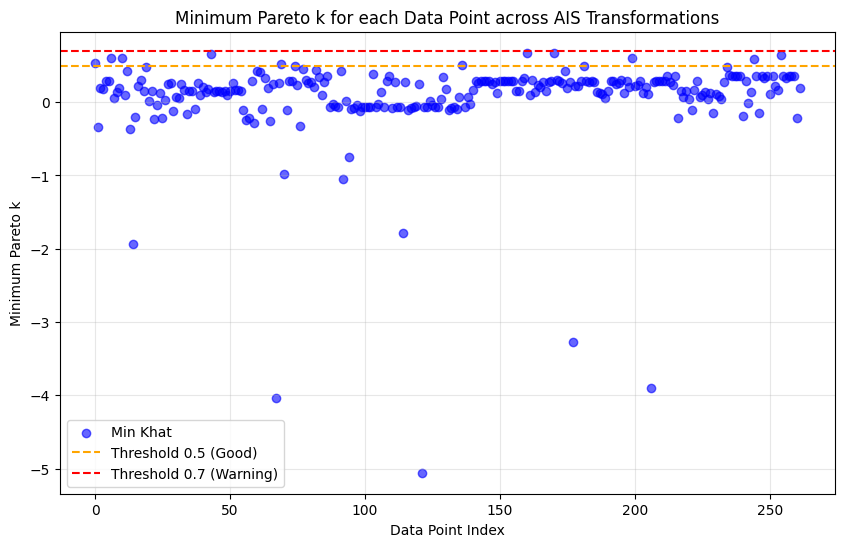

In [5]:
# Compare khat across methods
print('Comparing khat across methods...')
khats = []
method_names = []
for method, k_vals in method_khats.items():
    khats.append(k_vals)
    method_names.append(method)

khats = np.array(khats) # Shape: (n_methods, n_data)
min_khats = np.min(khats, axis=0)

# We don't have all methods' full khats for all points (only identity/bad points updated),
# but method_khats holds the "effective" khat per method (identity fallback).
# Actually method_khats has [observations] size for each method.

print(f'Min khat per data point (min/max): {min_khats.min():.3f}/{min_khats.max():.3f}')

# Create a scatter plot of min khat
plt.figure(figsize=(10, 6))
plt.scatter(range(len(min_khats)), min_khats, c='blue', alpha=0.6, label='Min Khat')
plt.axhline(y=0.5, color='orange', linestyle='--', label='Threshold 0.5 (Good)')
plt.axhline(y=0.7, color='red', linestyle='--', label='Threshold 0.7 (Warning)')
plt.xlabel('Data Point Index')
plt.ylabel('Minimum Pareto k')
plt.title('Minimum Pareto k for each Data Point across AIS Transformations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


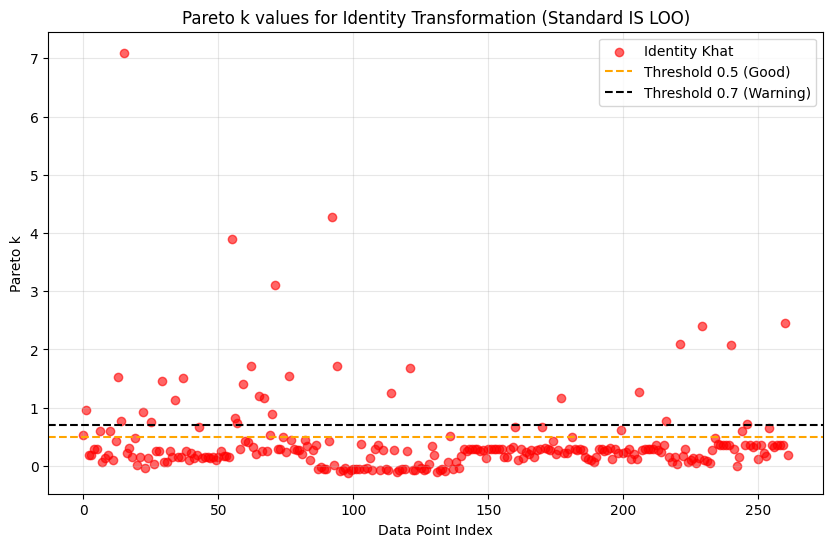

In [6]:
# Plot khat values for identity transformation
plt.figure(figsize=(10, 6))
plt.scatter(range(len(method_khats['identity'])), method_khats['identity'], c='red', alpha=0.6, label='Identity Khat')
plt.axhline(y=0.5, color='orange', linestyle='--', label='Threshold 0.5 (Good)')
plt.axhline(y=0.7, color='black', linestyle='--', label='Threshold 0.7 (Warning)')
plt.xlabel('Data Point Index')
plt.ylabel('Pareto k')
plt.title('Pareto k values for Identity Transformation (Standard IS LOO)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Found 31 points with identity khat >= 0.7


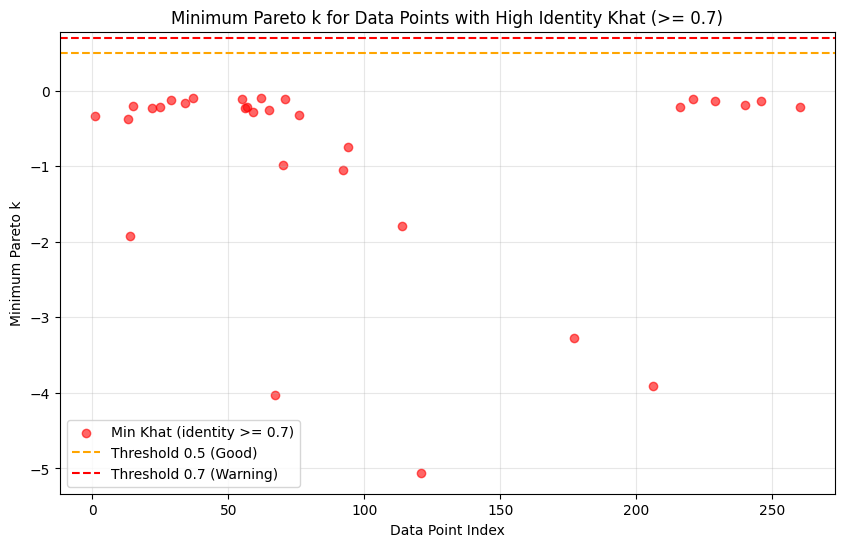

In [7]:
# Conditional plot: Min khat where identity khat >= 0.7
if 'identity' in method_khats:
    identity_khat = method_khats['identity']
    # Filter indices
    high_khat_indices = np.where(identity_khat >= 0.7)[0]
    
    if len(high_khat_indices) > 0:
        print(f"Found {len(high_khat_indices)} points with identity khat >= 0.7")
        min_khats_filtered = min_khats[high_khat_indices]
        
        plt.figure(figsize=(10, 6))
        plt.scatter(high_khat_indices, min_khats_filtered, c='red', alpha=0.6, label='Min Khat (identity >= 0.7)')
        plt.axhline(y=0.5, color='orange', linestyle='--', label='Threshold 0.5 (Good)')
        plt.axhline(y=0.7, color='red', linestyle='--', label='Threshold 0.7 (Warning)')
        plt.xlabel('Data Point Index')
        plt.ylabel('Minimum Pareto k')
        plt.title('Minimum Pareto k for Data Points with High Identity Khat (>= 0.7)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("No points found with identity khat >= 0.7")


PREDICTIVE CHECKS

Posterior Predictive Summary:
  Observed mean: 25.65
  Predicted mean: 25.64
  Observed std: 50.75
  Predicted std: 32.01


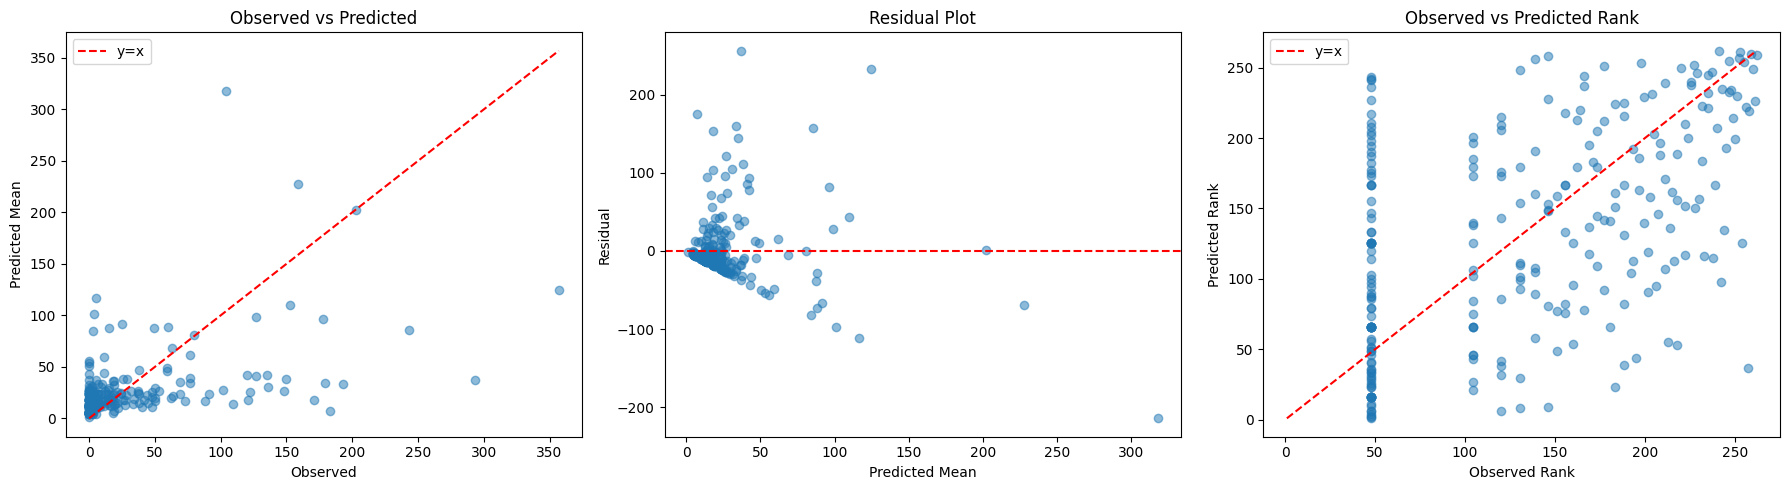

In [8]:
# Predictive checks

print('='*70)
print('PREDICTIVE CHECKS')
print('='*70)

# Sample posterior predictive
samples = model.mcmc_samples
n_posterior_samples = min(500, samples['beta'].shape[0] * samples['beta'].shape[1])
flat_beta = samples['beta'].reshape(-1, samples['beta'].shape[-1])
flat_intercept = samples['intercept'].reshape(-1, samples['intercept'].shape[-1])

# Sample indices
sample_idx = jax.random.choice(jax.random.PRNGKey(123), flat_beta.shape[0], 
                              shape=(n_posterior_samples,), replace=False)

# Get predictions
pred_means = []
for idx in sample_idx:
    params = {
        'beta': flat_beta[idx],
        'intercept': flat_intercept[idx],
    }
    
    pred_dist = model.predictive_distribution(data_dict, **params)
    pred_means.append(pred_dist['prediction'])

pred_means = jnp.array(pred_means)

# Compute summaries
pred_mean = pred_means.mean(axis=0)
pred_lower = jnp.percentile(pred_means, 2.5, axis=0)
pred_upper = jnp.percentile(pred_means, 97.5, axis=0)

print(f'\nPosterior Predictive Summary:')
print(f'  Observed mean: {y_data.mean():.2f}')
print(f'  Predicted mean: {pred_mean.mean():.2f}')
print(f'  Observed std: {y_data.std():.2f}')
print(f'  Predicted std: {pred_means.std():.2f}')

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Observed vs Predicted
axes[0].scatter(y_data, pred_mean, alpha=0.5)
axes[0].plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'r--', label='y=x')
axes[0].set_xlabel('Observed')
axes[0].set_ylabel('Predicted Mean')
axes[0].set_title('Observed vs Predicted')
axes[0].legend()

# Residuals
residuals = y_data - pred_mean
axes[1].scatter(pred_mean, residuals, alpha=0.5)
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Mean')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residual Plot')


# Observed vs Predicted Rank
obs_rank = pd.Series(y_data.flatten()).rank(method='average')
pred_rank = pd.Series(pred_mean).rank(method='average')
axes[2].scatter(obs_rank, pred_rank, alpha=0.5)
axes[2].plot([min(obs_rank.min(), pred_rank.min()), max(obs_rank.max(), pred_rank.max())], 
                [min(obs_rank.min(), pred_rank.min()), max(obs_rank.max(), pred_rank.max())], 'r--', label='y=x')
axes[2].set_xlabel('Observed Rank')
axes[2].set_ylabel('Predicted Rank')
axes[2].set_title('Observed vs Predicted Rank')
axes[2].legend()

plt.tight_layout()
plt.show()

print('\n' + '='*70)